In [1]:
import os
os.getcwd()

'C:\\Users\\us16120\\Projects\\Cheminformatics\\Similarity_and_Diversity'

#### Load libraries, prepare notebook environment

In [54]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import SimDivFilters
from rdkit import DataStructs

from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.RDLogger import logger

from IPython.core.display import HTML, display

%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

try:
    Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
    Draw.DrawingOptions.atomLabelFontSize = 18
except KeyError:  # Font "DejaVu Sans" is not available
    pass

#### Read data

In [11]:
df = pd.read_csv('omnis.csv')

In [12]:
df.sample(10).head(10)

Unnamed: 0 source_casrn                     Canonical_QSARr  \
8377          188     503-74-2                        CC(C)CC(O)=O   
33710        5136    5348-42-5                  Nc1cc(Cl)c(Cl)cc1N   
1192          202     636-28-2                Brc1cc(Br)c(Br)cc1Br   
17821        4037   54890-00-5              CCCC(C1CCCCC1)C1CCCCC1   
23168        7865  132899-69-5   CCOc1ccc(cc1NC(=O)CC)[N+]([O-])=O   
3638          736      91-20-3                      c1cccc2ccccc21   
2939          382     628-41-1                          C1C=CCC=C1   
3196         3691     771-99-3                  C1CC(CCN1)c1ccccc1   
33757        2244     461-88-1                      Nc1cc(N)[n]cc1   
36832         116      80-33-1  O=S(=O)(Oc1ccc(Cl)cc1)c1ccc(Cl)cc1   

                                        InChI_Code_QSARr  \
8377   InChI=1S/C5H10O2/c1-4(2)3-5(6)7/h4H,3H2,1-2H3,...   
33710  InChI=1S/C6H6Cl2N2/c7-3-1-5(9)6(10)2-4(3)8/h1-...   
1192      InChI=1S/C6H2Br4/c7-3-1-4(8)6(10)2-5(3)9/h1-2H   
17821  InChI=1S/C16H30/c1-2-9-16(14-10-5-3-6-11-14)15...   
23168  InChI=1S/C11H14N2O4/c1-3-11(14)12-9-7-8(13(15)...   
3638     InChI=1S/C10H8/c1-2-6-10-8-4-3-7-9(10)5-1/h1-8H   
2939        InChI=1S/C6H8/c1-2-4-6-5-3-1/h1-2,5-6H,3-4H2   
3196   InChI=1S/C11H15N/c1-2-4-10(5-3-1)11-6-8-12-9-7...   
33757  InChI=1S/C5H7N3/c6-4-1-2-8-5(7)3-4/h1-3H,(H4,6...   
36832  InChI=1S/C12H8Cl2O3S/c13-9-1-5-11(6-2-9)17-18(...   

                   InChI Key_QSARr  EndPtValue         EndPt  
8377   GWYFCOCPABKNJV-UHFFFAOYSA-N        1.00  Ready_Biodeg  
33710  IWFHBRFJOHTIPU-UHFFFAOYSA-N      160.50            MP  
1192   QCKHVNQHBOGZER-UHFFFAOYSA-N        1.35       LogKmHL  
17821  HYUXMTCTXARFET-UHFFFAOYSA-N      293.00            BP  
23168  IRCWXOXMYYBUJL-UHFFFAOYSA-N        1.85          LogP  
3638   UFWIBTONFRDIAS-UHFFFAOYSA-N       80.20            MP  
2939   UVJHQYIOXKWHFD-UHFFFAOYSA-N      -10.00         LogOH  
3196   UTBULQCHEUWJNV-UHFFFAOYSA-N       60.50            MP  
33757  IFFLKGMDBKQMAH-UHFFFAOYSA-N      107.00            MP  
36832  RZXLPPRPEOUENN-UHFFFAOYSA-N        0.00  Ready_Biodeg

#### SMILES >> Molecule ... success? / failure?

In [30]:
for i in range(len(df)):
    try:
        mol = Chem.MolFromSmiles(df.loc[i, 'Canonical_QSARr'])
    except:
        print('Bad Molecule ', i)  
    if not i % 10000: print(" processed %d" %i)

 processed 0
 processed 10000
 processed 20000
 processed 30000
 processed 40000


There are many duplicates (*i.e.,* the same molecule screened against multiple targets).

In [32]:
df.shape

(40271, 7)

In [33]:
df['InChI_Code_QSARr'].nunique()

22820

In [34]:
df['EndPt'].value_counts()

LogP            14039
MP               8653
BP               5435
LogMolar         4224
LogVP            2713
Ready_Biodeg     1608
LogKOC            729
LogOH             692
LogBCF            626
LogHL             591
LogKmHL           541
LogKOA            270
LogHalfLife       150
Name: EndPt, dtype: int64

#### Ready_Biodeg

In [44]:
rb_rows =  df['EndPt'] == 'Ready_Biodeg'
rb = df[rb_rows].reset_index()

In [45]:
rb.head()

index  Unnamed: 0 source_casrn                         Canonical_QSARr  \
0     12         405      52-51-7                 [O-][N+](=O)C(Br)(CO)CO   
1     24          80      76-06-2                 [O-][N+](=O)C(Cl)(Cl)Cl   
2     28         160     126-11-4                 [O-][N+](=O)C(CO)(CO)CO   
3    135          42      82-68-8  [O-][N+](=O)c1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl   
4    150         278   18708-70-8          [O-][N+](=O)c1c(Cl)cc(Cl)cc1Cl   

                                    InChI_Code_QSARr  \
0  InChI=1S/C3H6BrNO4/c4-3(1-6,2-7)5(8)9/h6-7H,1-2H2   
1                    InChI=1S/CCl3NO2/c2-1(3,4)5(6)7   
2  InChI=1S/C4H9NO5/c6-1-4(2-7,3-8)5(9)10/h6-8H,1...   
3  InChI=1S/C6Cl5NO2/c7-1-2(8)4(10)6(12(13)14)5(1...   
4  InChI=1S/C6H2Cl3NO2/c7-3-1-4(8)6(10(11)12)5(9)...   

               InChI Key_QSARr  EndPtValue         EndPt  
0  LVDKZNITIUWNER-UHFFFAOYSA-N         0.0  Ready_Biodeg  
1  LFHISGNCFUNFFM-UHFFFAOYSA-N         0.0  Ready_Biodeg  
2  OLQJQHSAWMFDJE-UHFFFAOYSA-N         1.0  Ready_Biodeg  
3  LKPLKUMXSAEKID-UHFFFAOYSA-N         0.0  Ready_Biodeg  
4  AEBJDOTVYMITIA-UHFFFAOYSA-N         0.0  Ready_Biodeg

In [46]:
rb = rb[['source_casrn', 'Canonical_QSARr', 'EndPtValue']]

In [48]:
rb.sample(5).head()

source_casrn                       Canonical_QSARr  EndPtValue
220      99-92-3                     CC(=O)c1ccc(N)cc1         0.0
892     126-73-8                CCCCOP(=O)(OCCCC)OCCCC         0.0
770     408-35-5                 CCCCCCCCCCCCCCCC(O)=O         1.0
677     103-23-1  CCCCC(COC(=O)CCCCC(=O)OCC(CCCC)CC)CC         1.0
190      74-83-9                                   CBr         0.0

#### Diversity Picking

##### Generate Morgan fingerprints

In [49]:
ms = []
for i in range(len(rb)):
    mol = Chem.MolFromSmiles(rb.loc[i, 'Canonical_QSARr'])
    ms.append(mol)
    if not i % 100: print(" processed %d" %i)

 processed 0
 processed 100
 processed 200
 processed 300
 processed 400
 processed 500
 processed 600
 processed 700
 processed 800
 processed 900
 processed 1000
 processed 1100
 processed 1200
 processed 1300
 processed 1400
 processed 1500
 processed 1600


In [51]:
fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(m, 2) for m in ms]

In [57]:
def dmat_sim(fps, ntopick):
    ds = []
    for i in range(1, len(fps)):
        ds.extend(DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i], returnDistance = True))
    mmp = SimDivFilters.MaxMinPicker()
    ids = mmp.Pick(np.array(ds), len(fps), ntopick)
    return ids

In [58]:
dmat_ids = dmat_sim(fps, 20)

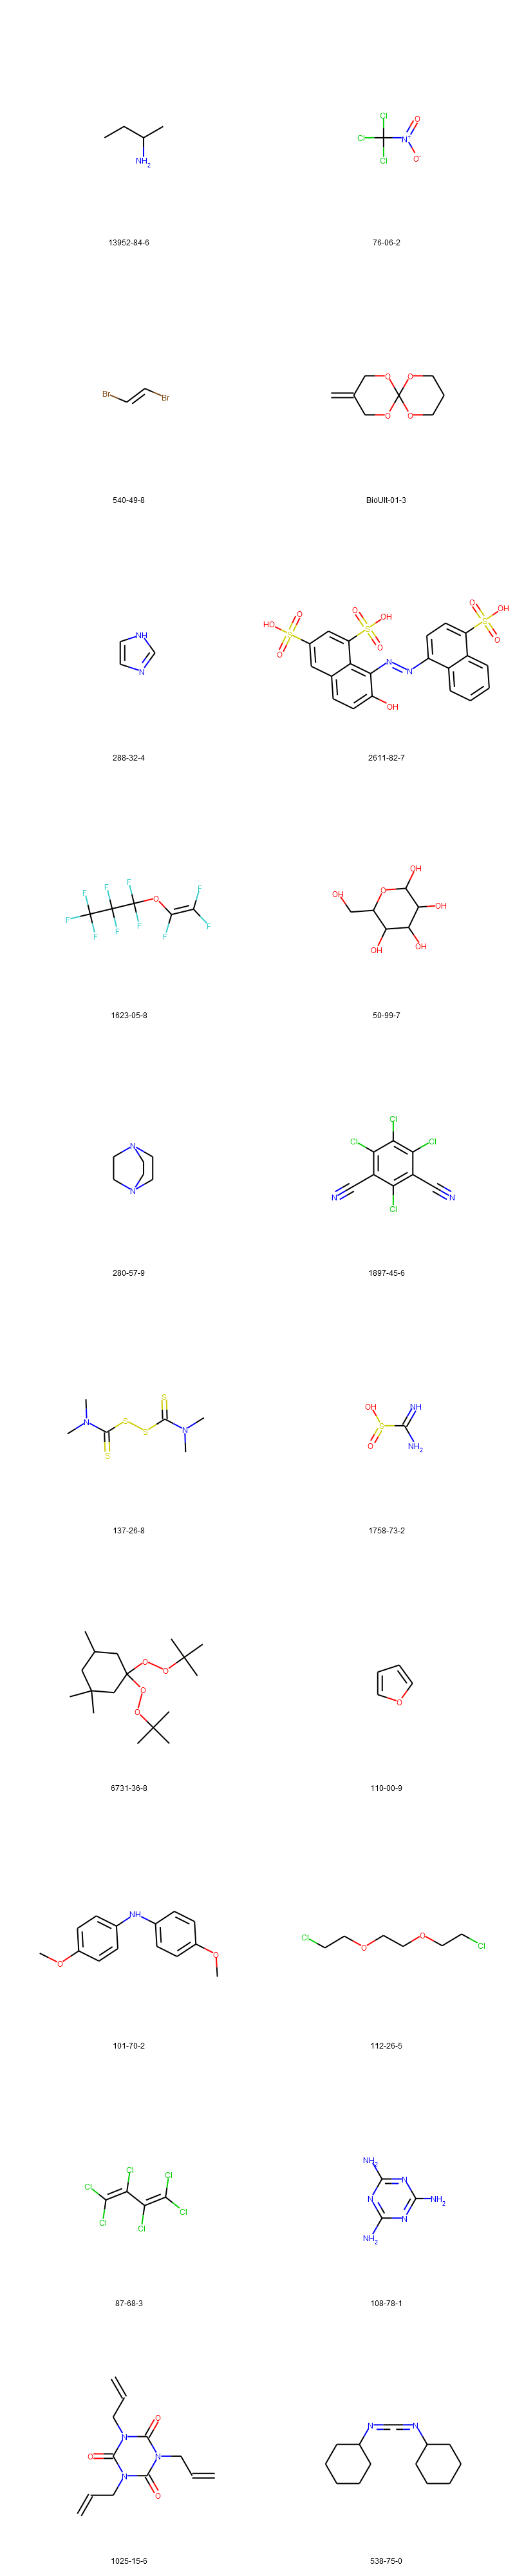

In [70]:
Draw.MolsToGridImage([ms[x] for x in dmat_ids[:20]], 
                     legends = [rb.iloc[x, 0] for x in dmat_ids[:20]],
                     subImgSize = (400, 400),
                     molsPerRow = 2)